In [1]:
# GIS imports
import rasterio

# Data analysis imports
from sklearn.ensemble import RandomForestClassifier
from skimage.segmentation import felzenszwalb
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import label2rgb
from tools import get_superpixel_stds_as_features, get_superpixel_means_as_features, get_array_from_features, reproject_arr_to_match_profile
from sklearn.model_selection import train_test_split
from skimage.restoration import denoise_tv_bregman

# misc imports
from pathlib import Path

Validation chip classifications:

0 – not water

1—water

7—will not classify (haven’t used this yet)

9—clouds (haven’t used this yet)

In [2]:
planet_ids = [f.name for f in Path('../data/planet_images_cropped').iterdir() if f.is_dir()]
cropped_chips = [list(Path(f'../data/planet_images_cropped/{id}').glob('cropped_*.tif'))[0] for id in planet_ids]
classification_chips = [list(Path(f'../data/planet_images_cropped/{id}').glob('classification_*.tif'))[0] for id in planet_ids]
full_images = [list(Path(f'../data/{id}/').glob('*.tif'))[0] for id in planet_ids]


print(list(map(len, [cropped_chips, classification_chips, full_images])))

[1, 1, 1]


### Example 1

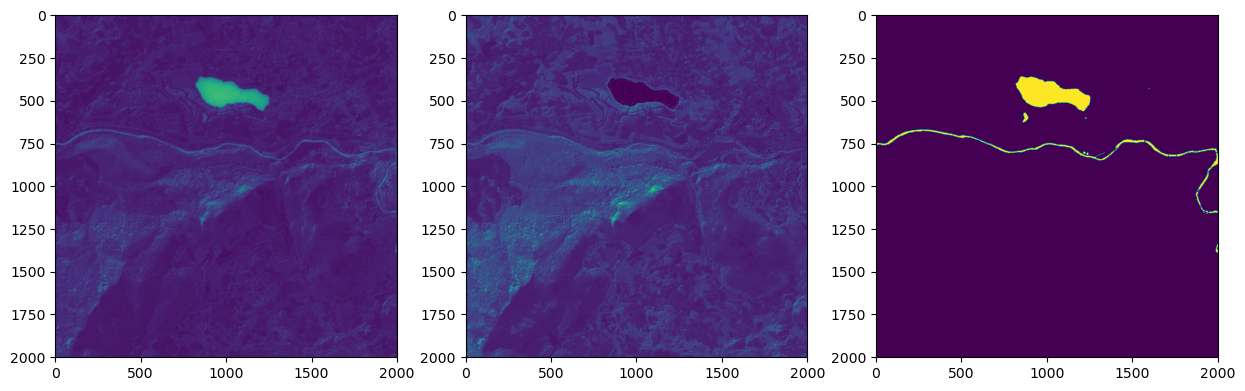

In [7]:
idx = 0
img, chip, classification = full_images[idx], cropped_chips[idx], classification_chips[idx]
min_value = 1 # filler value for data to prevent divide by zero errors

# chip = '/Users/karthikv/Desktop/workspace/my-repositories/DSWx-Validation-Dataset-Generation/planet_images_cropped/20211021_182217_09_2456/cropped_20211021_182217_09_2456.tif'
# classification='/Users/karthikv/Desktop/workspace/my-repositories/DSWx-Validation-Dataset-Generation/planet_images_cropped/20211021_182217_09_2456/classification_reviewed_20211021_182217_09_2456_formatted.tif'

with rasterio.open(classification) as ds:
    cl = ds.read(1)
    cl_profile = ds.profile

with rasterio.open(chip) as ds:
    green = ds.read(4)
    red = ds.read(7)
    nir = ds.read(8)

    red = np.where(red==0, min_value, red)
    nir = np.where(nir==0, min_value, nir)
    green = np.where(green==0, min_value, green)

    ndwi_1 = (green - nir)/(green + nir)
    ndwi_2 = (green - red)/(green + red)
    ref_profile = ds.profile

# some classification extents are not the same as the corresponding chip extent
if ref_profile['transform'] != cl_profile['transform']:
    ref_transform = ref_profile['transform']
    width = ref_profile['width']
    height = ref_profile['height']
    ref_profile = cl_profile.copy()
    ref_profile.update({'transform':ref_transform, 'width':width, 'height': height})
    cl, _ = reproject_arr_to_match_profile(cl, cl_profile, ref_profile)
    cl = np.squeeze(cl)


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(ndwi_1)
ax[1].imshow(ndwi_2)
ax[2].imshow(cl, vmax=1)

In [8]:
red_denoised = denoise_tv_bregman(red, weight=3)
nir_denoised = denoise_tv_bregman(nir, weight=3)
green_denoised = denoise_tv_bregman(green, weight=3)

ndwi_1 = (green_denoised - nir_denoised)/(green_denoised + nir_denoised)
ndwi_2 = (green_denoised - red_denoised)/(green_denoised + red_denoised)

img_stack = np.stack([red_denoised, nir_denoised, ndwi_1, ndwi_2], axis=-1)
segments = felzenszwalb(img_stack, sigma=0, min_size=3)

std_features = get_superpixel_stds_as_features(segments, img_stack)
mean_features = get_superpixel_means_as_features(segments, img_stack)

# Build training data array
X = np.concatenate([mean_features, std_features], axis = 1)

# We have superpixels, we now need to map each of the segments to the associated label
# A 0 value indicates no label for the segment
class_features = np.zeros((mean_features.shape[0], 1))
for class_id in [0, 1]:
    # Get all superpixel labels with particular id
    superpixel_labels_for_class = np.unique(segments[class_id == cl])
    # Label those superpixels with approrpriate class
    class_features[superpixel_labels_for_class] = class_id

class_arr_superpixels = get_array_from_features(segments, class_features)

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, class_features, test_size=0.15, random_state=0)

# Define an RF to be trained. setting n_jobs = -1 uses all available processors
rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0, n_jobs=-1)

# train model and print performance
rf.fit(X_train, y_train)
print("Model OOB score: ", rf.oob_score_)
print("Model test score: ", rf.score(X_test, y_test))

/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_21044/3689802993.py:9: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_stack, sigma=0, min_size=3)
/Users/karthikv/mambaforge/envs/expand-validation/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:640: RuntimeWarning: invalid value encountered in divide
  means = sums / counts
/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_21044/3689802993.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Model OOB score:  0.9950318448653493
Model test score:  0.9946856220288816


In [9]:
with rasterio.open(img) as ds:
    green = ds.read(4)
    red = ds.read(7)
    nir = ds.read(8)

    red = np.where(red==0, min_value, red)
    nir = np.where(nir==0, min_value, nir)
    green = np.where(green==0, min_value, green)

red_denoised = denoise_tv_bregman(red, weight=3)
nir_denoised = denoise_tv_bregman(nir, weight=3)
green_denoised = denoise_tv_bregman(green, weight=3)

ndwi_1 = (green_denoised - nir_denoised)/(green_denoised + nir_denoised)
ndwi_2 = (green_denoised - red_denoised)/(green_denoised + red_denoised)

img_stack = np.stack([red_denoised, nir_denoised, ndwi_1, ndwi_2], axis=-1)
segments = felzenszwalb(img_stack, sigma=0, min_size=3)

std_features = get_superpixel_stds_as_features(segments, img_stack)
mean_features = get_superpixel_means_as_features(segments, img_stack)

X = np.concatenate([mean_features, std_features], axis = 1)
y = rf.predict(X)

/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_21044/732477575.py:18: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_stack, sigma=0, min_size=3)
/Users/karthikv/mambaforge/envs/expand-validation/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:640: RuntimeWarning: invalid value encountered in divide
  means = sums / counts


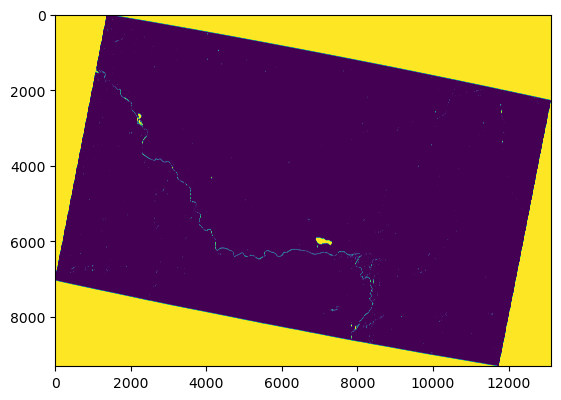

In [10]:
output = get_array_from_features(segments, np.expand_dims(y, axis=1))
plt.imshow(output, vmax=1)

with rasterio.open(img) as src_ds:
    profile_copy = src_ds.profile
    profile_copy.update({'count':1, 'dtype':np.uint8, 'nodata':255})
    with rasterio.open(f"{classification.parent}/full_chip_1_{classification.name}", 'w', **profile_copy) as dst_ds:
        dst_ds.write(output.astype(np.uint8).reshape(1, *output.shape))

### Example 2

In [114]:
idx = 1
img, chip, classification = full_images[idx], cropped_chips[idx], classification_chips[idx]
min_value = 1 # filler value for data to prevent divide by zero errors

with rasterio.open(classification) as ds:
    cl = ds.read(1)

with rasterio.open(chip) as ds:
    green = ds.read(4)
    red = ds.read(7)
    nir = ds.read(8)

    red = np.where(red==0, min_value, red)
    nir = np.where(nir==0, min_value, nir)
    green = np.where(green==0, min_value, green)

red_denoised = denoise_tv_bregman(red, weight=3)
nir_denoised = denoise_tv_bregman(nir, weight=3)
green_denoised = denoise_tv_bregman(green, weight=3)

ndwi_1 = (green_denoised - nir_denoised)/(green_denoised + nir_denoised)
ndwi_2 = (green_denoised - red_denoised)/(green_denoised + red_denoised)

img_stack = np.stack([red_denoised, nir_denoised, ndwi_1, ndwi_2], axis=-1)
segments = felzenszwalb(img_stack, sigma=0, min_size=3)

std_features = get_superpixel_stds_as_features(segments, img_stack)
mean_features = get_superpixel_means_as_features(segments, img_stack)

# Build training data array
X = np.concatenate([mean_features, std_features], axis = 1)

# We have superpixels, we now need to map each of the segments to the associated label
# A 0 value indicates no label for the segment
class_features = np.zeros((mean_features.shape[0], 1))
for class_id in [0, 1]:
    # Get all superpixel labels with particular id
    superpixel_labels_for_class = np.unique(segments[class_id == cl])
    # Label those superpixels with approrpriate class
    class_features[superpixel_labels_for_class] = class_id

class_arr_superpixels = get_array_from_features(segments, class_features)

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, class_features, test_size=0.15, random_state=0)

# Define an RF to be trained. setting n_jobs = -1 uses all available processors
rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0, n_jobs=-1)

# train model and print performance
rf.fit(X_train, y_train)
print("Model OOB score: ", rf.oob_score_)
print("Model test score: ", rf.score(X_test, y_test))

/tmp/ipykernel_167154/883137332.py:27: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_stack, sigma=0, min_size=3)
/u/trappist-r0/karthikv/mambaforge/envs/expand-validation/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:640: RuntimeWarning: invalid value encountered in divide
  means = sums / counts
/tmp/ipykernel_167154/883137332.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Model OOB score:  0.9984386850916626
Model test score:  0.9983856596257665


In [115]:
with rasterio.open(img) as ds:
    green = ds.read(4)
    red = ds.read(7)
    nir = ds.read(8)

    red = np.where(red==0, min_value, red)
    nir = np.where(nir==0, min_value, nir)
    green = np.where(green==0, min_value, green)

red_denoised = denoise_tv_bregman(red, weight=3)
nir_denoised = denoise_tv_bregman(nir, weight=3)
green_denoised = denoise_tv_bregman(green, weight=3)

ndwi_1 = (green_denoised - nir_denoised)/(green_denoised + nir_denoised)
ndwi_2 = (green_denoised - red_denoised)/(green_denoised + red_denoised)

img_stack = np.stack([red_denoised, nir_denoised, ndwi_1, ndwi_2], axis=-1)
segments = felzenszwalb(img_stack, sigma=0, min_size=3)

std_features = get_superpixel_stds_as_features(segments, img_stack)
mean_features = get_superpixel_means_as_features(segments, img_stack)

X = np.concatenate([mean_features, std_features], axis = 1)
y = rf.predict(X)

/tmp/ipykernel_167154/732477575.py:18: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_stack, sigma=0, min_size=3)
/u/trappist-r0/karthikv/mambaforge/envs/expand-validation/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:640: RuntimeWarning: invalid value encountered in divide
  means = sums / counts


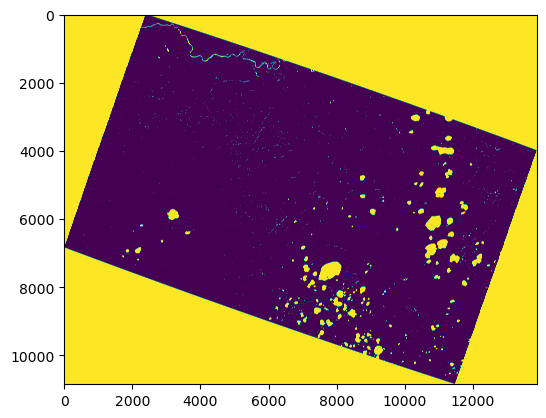

In [116]:
output = get_array_from_features(segments, np.expand_dims(y, axis=1))
plt.imshow(output, vmax=1)

with rasterio.open(img) as src_ds:
    profile_copy = src_ds.profile
    profile_copy.update({'count':1, 'dtype':np.uint8, 'nodata':255})
    with rasterio.open(f"{classification.parent}/full_chip_1_{classification.name}", 'w', **profile_copy) as dst_ds:
        dst_ds.write(output.astype(np.uint8).reshape(1, *output.shape))